# Mise en place du notebook

## Versionning

P6 v7 : avant split entre "P6 part1 v01" (contient la récupération des données et le SIFT) et "P6 part2 v01" (contient VGG-16).  
P6 part2 : début VGG-16.

## Import des modules

In [62]:
# imports pour le développement
from pympler import asizeof
import mesfonctions
from importlib import reload
mesfonctions = reload(mesfonctions)

# imports pour la production
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rcParams
from cycler import cycler
from dataprep.eda import create_report
from sklearn import decomposition
from sklearn import cluster, manifold, decomposition, preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from mesfonctions import display_scree_plot, display_factorial_planes
import pickle
from termcolor import colored, cprint
import cv2
from yellowbrick.cluster import KElbowVisualizer
import random
from collections import Counter

## Fonctions courantes

In [27]:
def nom_fichier_photo(index, df=None):
    """Retourne le chemin + nom du fichier jpg d'une ligne de dataframe.
    Args : 
    - index : index de la ligne de df.
    Returns :
    - string.
    """
    if df is None:
        df = df_source
    return PATH + df['image'][index]

## Constantes

In [3]:
PATH = "Images_Flipkart/"

## Gestion des paramètres d'affichage de Jupyter

In [4]:
from IPython.core.display import HTML
plt.style.use('seaborn')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

# Chargement du dataframe

In [7]:
df_source = pickle.load(open('df_source.pkl', 'rb'))

# VGG-16

## Feature extraction

On déroule cette méthodologie :  
    https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/  
Chapitre : Pre-Trained Model as Feature Extractor Preprocessor  

In [13]:
# example of using the vgg16 model as a feature extraction model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [32]:
def VGG16_extracteur(nom_image='cat.jpg'):
    # load an image from file
    image = load_img(nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # load model
    model = VGG16()
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # get extracted features
    im_features = model.predict(image)
    return im_features
    
# test unitaire
VGG16_extracteur()

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
list_features = []
for i in range(len(df_source)):
    if i%10 == 0 : print(i, "", end='')
    nom_image = nom_fichier_photo(i)
    list_features.append(VGG16_extracteur(nom_image))

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 

In [38]:
# Sauvegarde des descripteurs calculés (pickle)
pickle.dump(list_features, open('list_features_VGG16.pkl', 'wb'))

In [39]:
# Chargement des descripteurs calculés (pickle)
list_features = pickle.load(open('list_features_VGG16.pkl', 'rb'))

In [43]:
arr_features = np.asarray(list_features)
display (arr_features)

array([[[3.3986144 , 0.8595722 , 0.        , ..., 0.        , 0.8510551 , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 1.2970998 , 0.        , 0.        ]],

       ...,

       [[2.1961298 , 2.3982751 , 2.6236405 , ..., 2.159872  , 0.18472159, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        , 0.24833043, 0.9251383 ]],

       [[0.        , 0.        , 0.1231316 , ..., 0.        , 0.5277166 , 2.9917495 ]]], dtype=float32)

In [44]:
arr_features = np.concatenate(arr_features, axis=0)
display (arr_features)

array([[3.3986144 , 0.8595722 , 0.        , ..., 0.        , 0.8510551 , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 1.2970998 , 0.        , 0.        ],
       ...,
       [2.1961298 , 2.3982751 , 2.6236405 , ..., 2.159872  , 0.18472159, 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.24833043, 0.9251383 ],
       [0.        , 0.        , 0.1231316 , ..., 0.        , 0.5277166 , 2.9917495 ]], dtype=float32)

In [45]:
arr_features.shape

(1050, 4096)

## Réduction de dimension

### Réduction de dimension PCA

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 850)


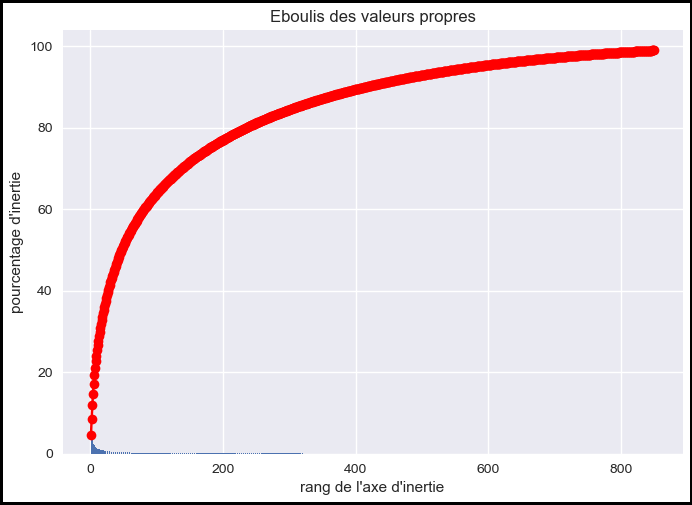

In [218]:
print("Dimensions dataset avant réduction PCA : ", arr_features.shape)
pca = decomposition.PCA(n_components=0.99)
arr_features_scaled = preprocessing.StandardScaler().fit_transform(arr_features)   # données centrées réduites
# arr_features_scaled = arr_features
feat_pca= pca.fit_transform(arr_features_scaled)
# feat_pca = arr_features_scaled
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

### Visualisation par t-SNE

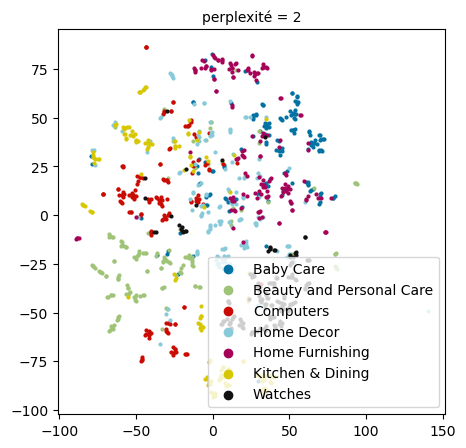

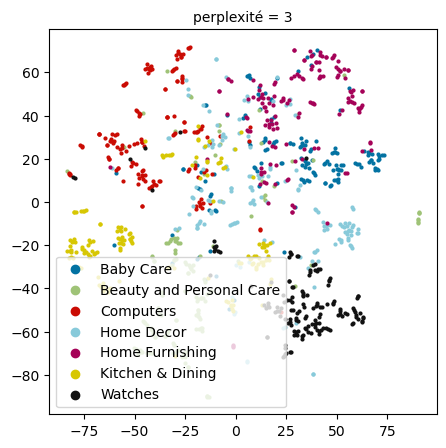

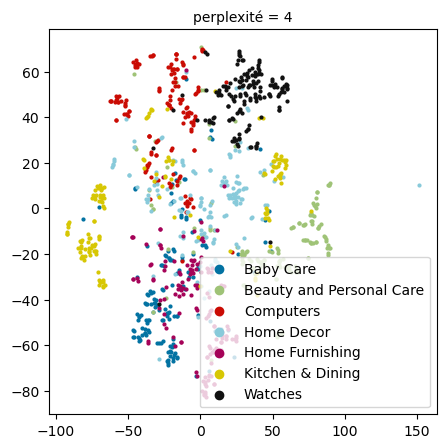

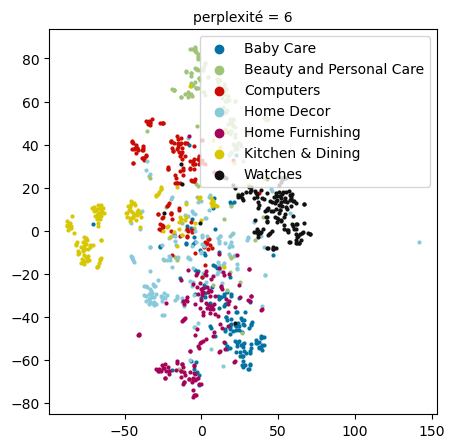

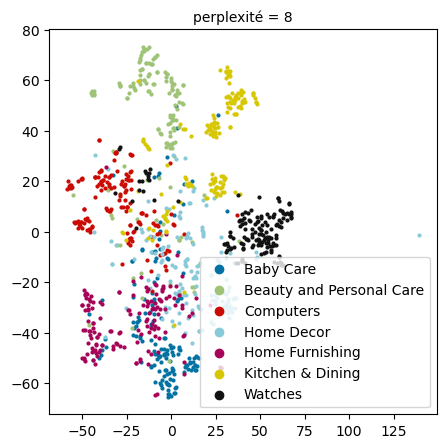

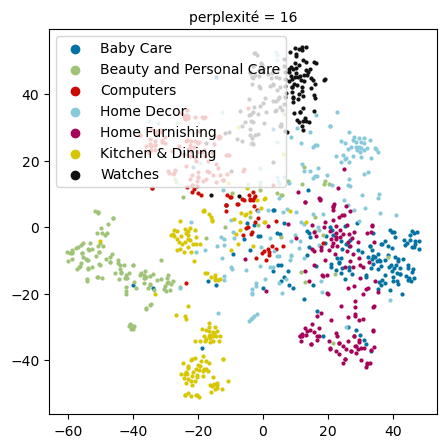

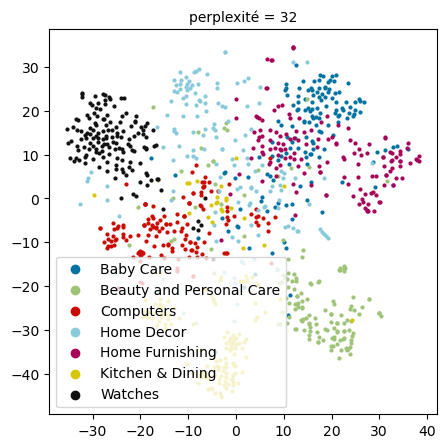

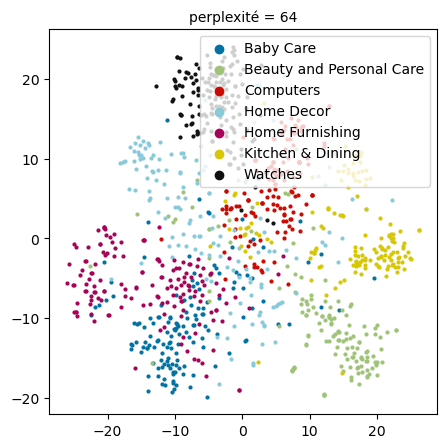

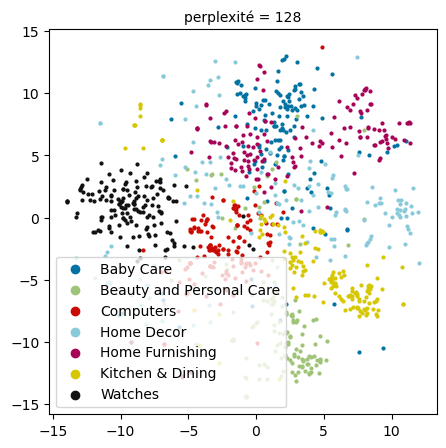

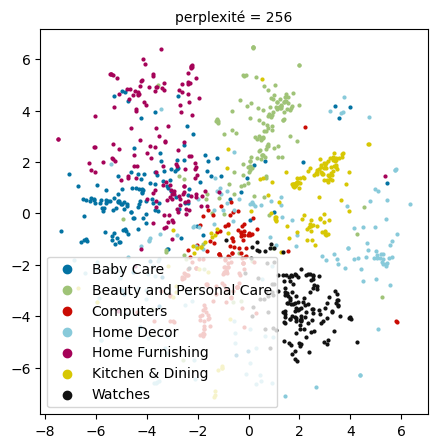

In [55]:
perplexities = [2, 3, 4, 6, 8, 16, 32, 64, 128, 256]
# perplexities = [30]

plt.style.use('default')
rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

for perplexity in perplexities:
    plt.figure(figsize=(5, 5))
    tsne = manifold.TSNE(n_components=2, random_state=0, perplexity=perplexity)
    data_reduced_tsne = tsne.fit_transform(feat_pca)
    illustrative_var = np.array(df_source['label'])
    for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(data_reduced_tsne[selected, 0], data_reduced_tsne[selected, 1], s=4, label=value)
    plt.title('perplexité = ' + str(perplexity), fontsize=10)
    plt.legend(markerscale=3, frameon=True)
    plt.show()

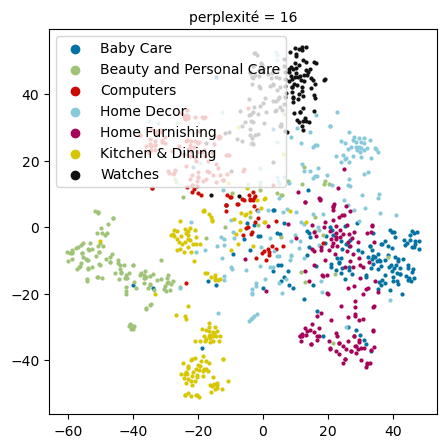

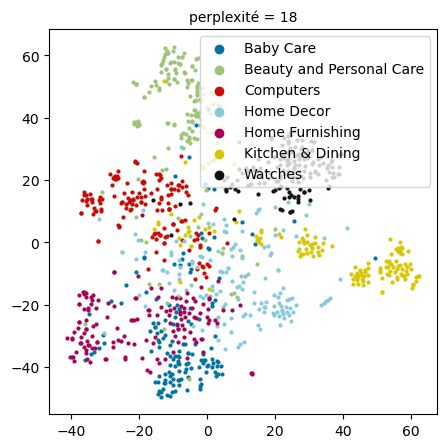

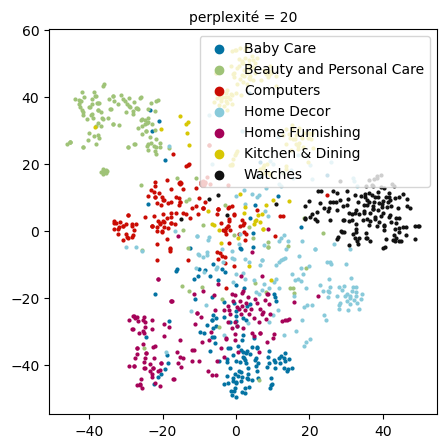

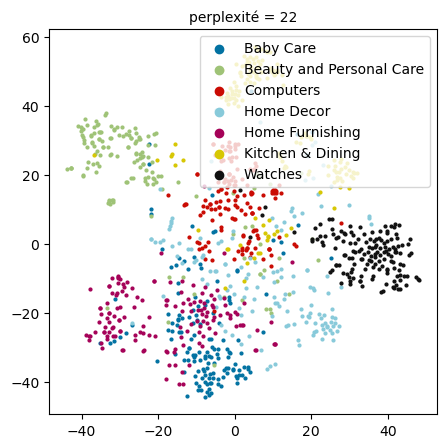

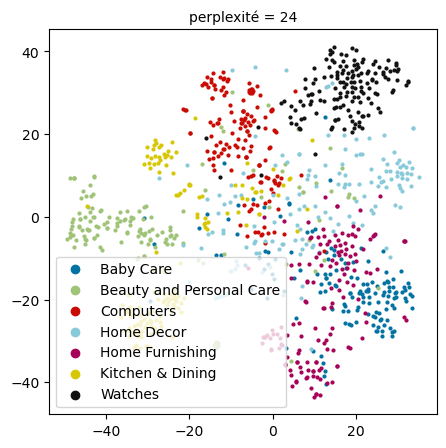

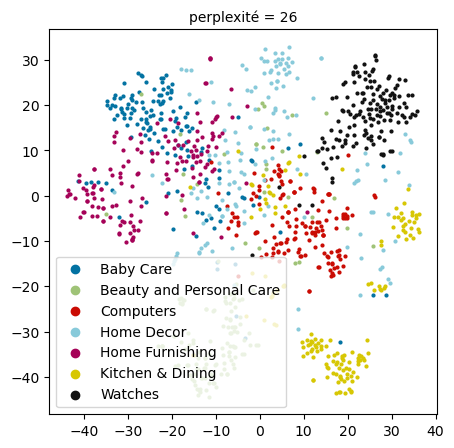

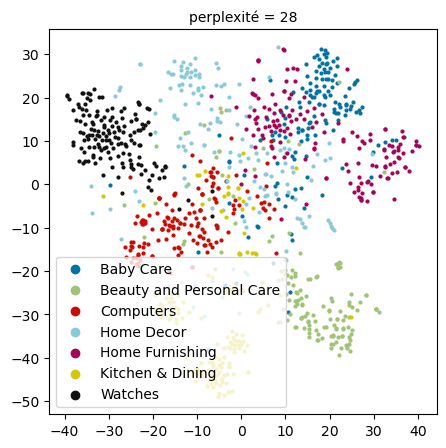

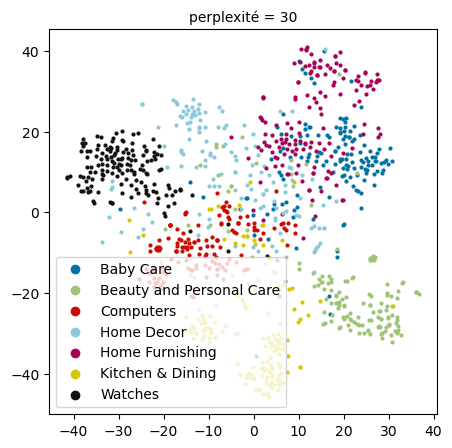

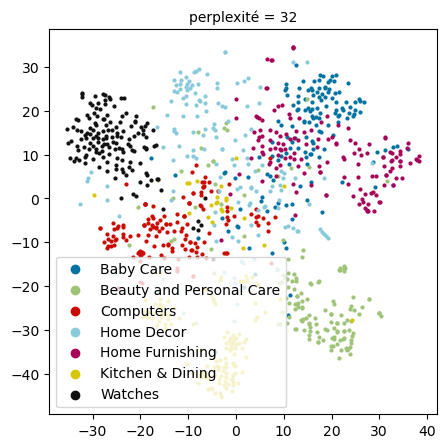

In [58]:
perplexities = range(16,33,2)

plt.style.use('default')
rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

for perplexity in perplexities:
    plt.figure(figsize=(5, 5))
    tsne = manifold.TSNE(n_components=2, random_state=0, perplexity=perplexity)
    data_reduced_tsne = tsne.fit_transform(feat_pca)
    illustrative_var = np.array(df_source['label'])
    for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(data_reduced_tsne[selected, 0], data_reduced_tsne[selected, 1], s=4, label=value)
    plt.title('perplexité = ' + str(perplexity), fontsize=10)
    plt.legend(markerscale=3, frameon=True)
    plt.show()

## Clustering des images par k-means

### Méthode du coude sur l'inertie pour déterminer le k optimum

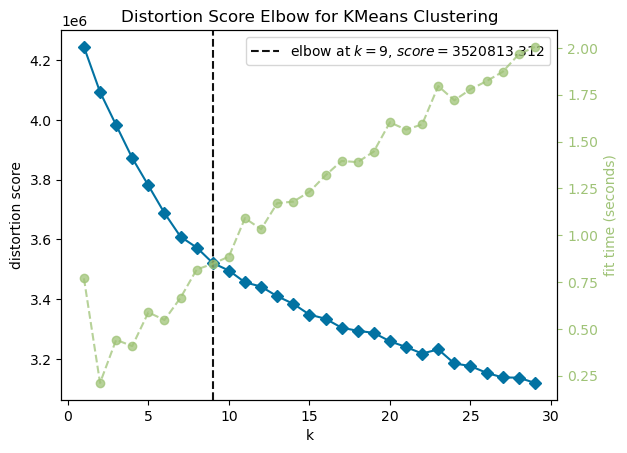

In [49]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 30))

visualizer.fit(feat_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

### Score de silhouette pour déterminer le k optimum

In [134]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(feat_pca)
                for k in range(1, 15)]

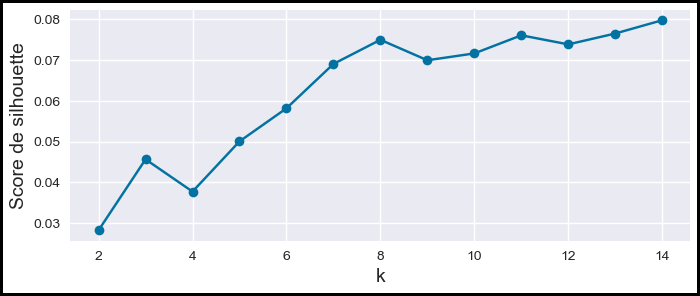

In [135]:
silhouette_scores = [silhouette_score(feat_pca, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

plt.style.use('seaborn')
plt.figure(figsize=(8, 3), edgecolor='black', linewidth=4)
plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Score de silhouette", fontsize=14)
plt.show()

### Diagrammes de silhouette

In [52]:
def diagramme_silhouette(data_scaled, kmeans_per_k):
    """ Affichage du diagramme de silhouette
    Args : 
    - kmeans_per_k : liste des modélisations pour k=1 (oui, k=1) à k=k_max.
    - data_scaled : dataframe pandas converti, centré et normalisé.
    Returns :
    - tracés matplotlib (pour k=2 à k=k_max).
    """
    plt.style.use('seaborn')
    plt.figure(figsize=(11, 13), edgecolor='black', linewidth=4)
    
    silhouette_scores = [silhouette_score(data_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

    for k in range(2, 11):
        plt.subplot(3, 3, k - 1)

        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(data_scaled,
                                                     y_pred)

        padding = len(data_scaled) // 30
        pos = padding
        ticks = []

        # on trie les clusters du plus petit au plus grand
        taille_clusters = {}
        for i in range(k):
            taille_clusters[i] = len(silhouette_coefficients[y_pred == i])
        taille_clusters = {
            k: v
            for k, v in sorted(taille_clusters.items(),
                               key=lambda item: item[1])
        }
        i_color = 0
        for i in reversed(taille_clusters.keys()):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()
            color = mpl.cm.Spectral(i_color / (k - 1))
            i_color += 1
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)),
                              0,
                              coeffs,
                              facecolor=color,
                              edgecolor=color,
                              alpha=1)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(
            FixedFormatter(list(reversed(taille_clusters.keys()))))
        if k in (2, 5, 8):
            plt.ylabel("Cluster")
        plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        if k in (8, 9, 10):
            plt.xlabel("Coefficient de silhouette")
        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=14)

    plt.show()

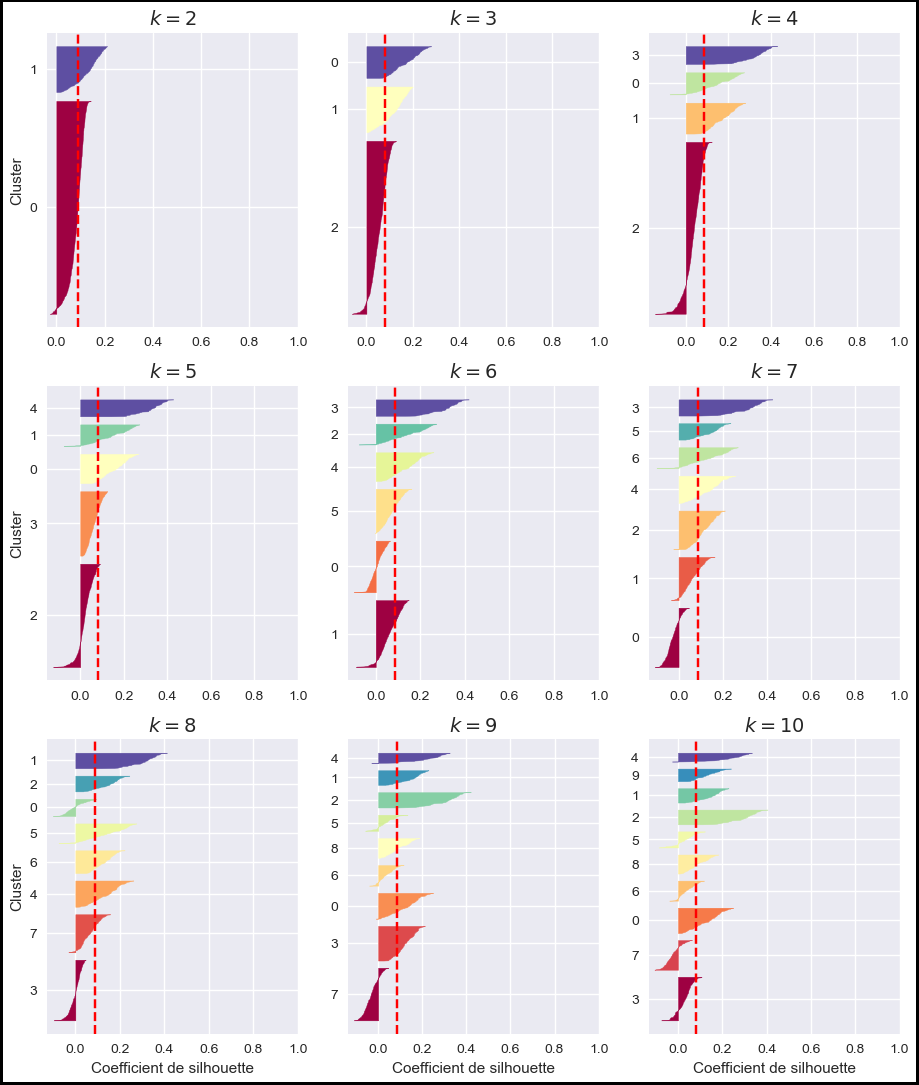

In [110]:
diagramme_silhouette(feat_pca, kmeans_per_k)

### Adjusted Rand Score pour les 7 catégories labellisées

#### Conditions standard de PCA (99% d'inertie)

In [188]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.49039410171632797


#### Résultats issus de modifications de l'étape de PCA

###### Sans StandardScaler

On omet le StandardScaler avant la PCA.  
C'est globalement un peu meilleur avec StandardScaler.  
Note : 803 dimensions (vs 850) avec PCA à 99% d'inertie.  

In [190]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4768143608291434


###### Sans PCA (et avec StandardScaler)

4096 dimensions

In [216]:
model = KMeans(n_clusters=7, random_state=0, n_init=20000).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.49272122875957286


###### PCA à 95% d'inertie

581 dimensions post PCA  

In [186]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.49752548907902355


###### PCA à 90% d'inertie

414 dimensions post PCA  

In [184]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4915546841879664


###### PCA à 80% d'inertie

235 dimensions post PCA  

In [194]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4965216221037307


###### PCA à 60% d'inertie

82 dimensions post PCA  

In [197]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4924223368835112


###### PCA à 40% d'inertie

27 dimensions post PCA  

In [199]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.49312135421548947


###### PCA à 20% d'inertie

7 dimensions post PCA  

In [201]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.5159241544434252


###### PCA => 3 dimensions

In [208]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.46549647321688403


###### PCA => 2 dimensions

In [210]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.347854499444082


###### PCA => 1 dimension

In [212]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.20887099064066397


### Comparaison graphique entre les valeurs "true" et le partitionnement proposé par le k-means

In [96]:
def graphe_tsne(feat_pca, perplexity, illustrative_var):
    """ Visualisation t-SNE en 2 dimensions, avec ajout de labels de couleurs sur les données.
    Args :
    - feat_pca : la data à réduire par le t-SNE
    - perplexity : perplexité du t-SNE
    - illustrative_var : série avec les labels de la data
    Returns :
    - void (tracé matplotlib)
    """
    plt.style.use('default')
    rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

    for perplexity in perplexities:
        plt.figure(figsize=(5, 5))
        tsne = manifold.TSNE(n_components=2, random_state=0, perplexity=perplexity)
        data_reduced_tsne = tsne.fit_transform(feat_pca)
        illustrative_var = np.array(illustrative_var) 
        for value in np.unique(illustrative_var):
            selected = np.where(illustrative_var == value)
            plt.scatter(data_reduced_tsne[selected, 0], data_reduced_tsne[selected, 1], s=4, label=value)
        plt.title('perplexité = ' + str(perplexity), fontsize=10)
        plt.legend(fontsize=8, markerscale=3, frameon=False)
        plt.show()

#### k-means 7 clusters

In [94]:
kmeans_per_k[6]

KMeans(n_clusters=7, random_state=0)

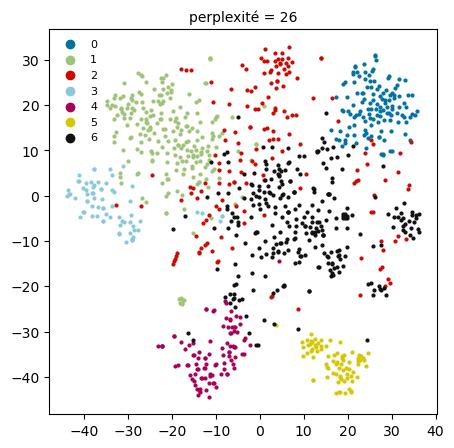

In [97]:
graphe_tsne(feat_pca, 26, kmeans_per_k[6].labels_)

#### Pour rappel, les labels "true"

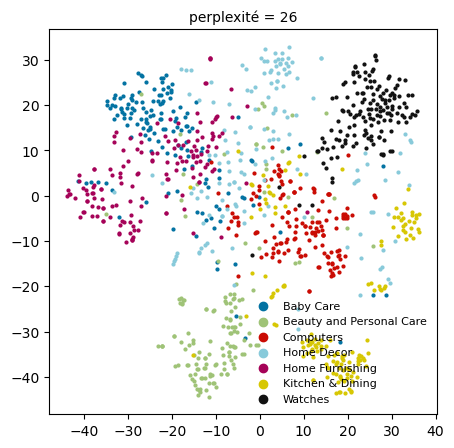

In [98]:
graphe_tsne(feat_pca, 26, df_source['label'])

#### k-means 6 clusters  (l'ARI est meilleur)

In [70]:
kmeans_per_k[5]

KMeans(n_clusters=6, random_state=0)

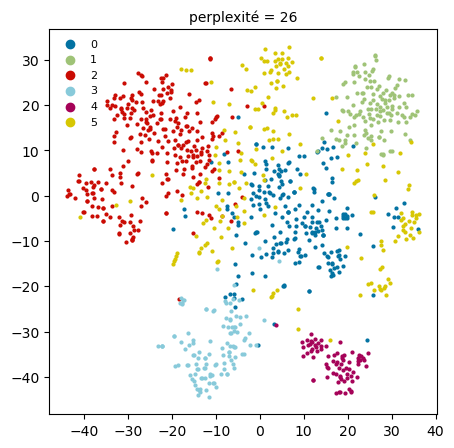

In [99]:
graphe_tsne(feat_pca, 26, kmeans_per_k[5].labels_)

En diminuant le nb de clusters de 1, on observe que les catégories "Home Furnishing" et "Baby Care" ont fusionné (label rouge).